# SETTINGS

Esta nb genera una base de datos con boletines oficiales nacionales entre junio 2017 y fines de 2022.

## Libraries

In [2]:
import fitz
import os
import shutil
import re
import pandas as pd
import numpy as np
from functools import wraps
import time
import re
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()
        total_time = end_time - start_time
        # print(f'Function {func.__name__}{args} {kwargs} Took {total_time:.4f} seconds')
        print(f'Function {func.__name__} Took {total_time:.4f} seconds',end='\r')
        return result
    return timeit_wrapper

def is_valid_path(path):
    try:
        # If the path is absolute or can be made absolute, it's considered a valid path
        absolute_path = os.path.abspath(path)
        return os.path.exists(absolute_path)
    except OSError:
        return False

    
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\1_2024\\projects\\wally_west\\2_pdfs_parsing'

## Eliminamos archivos duplicados

In [6]:
len('seccion_segunda_20170601.pdf'), len('seccion_segunda_20220202 - 2023-05-10T053927.729.pdf')

(28, 52)

In [5]:
# buscamos los archivos duplicados (tienen un largo de titulo excepcional)
path = r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\1_2024\\projects\\wally_west\\0_data\\boletines'
files = os.listdir(path)
files_to_delete = [file for file in files if len(file)>28]
len(files), len(files_to_delete)

(1200, 0)

In [8]:
os.chdir(path)
os.getcwd()

files = [f for f in files if '.pdf' in f]
files = [f for f in files if len(f) <30]

len(files)

1198

In [9]:
# creamos lista de rutas:
paths_to_files_to_delete = [*map(os.path.join,np.repeat(path, len(files_to_delete)),files_to_delete)]

# eliminamos los archivos:
print(len(os.listdir(path)))
# map(os.remove,paths_to_files_to_delete)
for file in paths_to_files_to_delete:
    os.remove(file)
print(len(os.listdir(path)))

1200
1200


# Extracción de Datos de Boletines

In [12]:
@timeit
def generamos_df(path):
    '''
    
    '''
    if is_valid_path(path):
        doc = fitz.open(path)
    
    else:
        doc = path

    data = []

    for n, page in enumerate(doc):
        blocks = page.get_text("dict", flags=11)["blocks"]
        for block in blocks:
            font = block['lines'][0]['spans'][0]['font']
            size = block['lines'][0]['spans'][0]['size']
            
            text = ''
            for i in block['lines']:
                for j in i['spans']:
                    try:
                        text += j['text']
                    except:
                        pass
            # text = block['lines'][0]['spans'][0]['text']
            
            page_num = n

            if size != 8.5:
                data.append((path,page_num, font, size, text))

    columns = ['file','page', 'font', 'size', 'text']
    df = pd.DataFrame(data, columns=columns)

    df['chapter'] = df.loc[df['size'] == 17, 'text']
    df['subchapter'] = df.loc[df['size'] == 14, 'text']
    df['title'] = df.loc[df['size'] == 11, 'text']
    
    
    df['chapter'] = df['chapter'].fillna(method='ffill')
    df['subchapter'] = df['subchapter'].fillna(method='ffill')
    df['title'] = df['title'].fillna(method='ffill')
    
    return df.reset_index()

In [15]:
%%time
df_ls = [generamos_df(doc) for doc in files[0:10]]
# df_ls = [generamos_df(doc) for doc in files]

CPU times: total: 3.06 sok 0.3078 seconds
Wall time: 3.02 s


In [16]:
%%time
result_df = pd.concat(df_ls, ignore_index=True)
result_df.head()

CPU times: total: 15.6 ms
Wall time: 4 ms


,index,file,page,font,size,text,chapter,subchapter,title
0,0,seccion_segunda_20170601.pdf,0,HelveticaNeueLTStd-LtCn,10.550829,1. Contratos sobre Personas Jurídicas2. Convoc...,NaN,NaN,NaN
1,1,seccion_segunda_20170601.pdf,0,HelveticaNeueLTStd-LtCn,10.550829,3. Edictos Judiciales4. Partidos Políticos5. I...,NaN,NaN,NaN
2,2,seccion_segunda_20170601.pdf,0,HelveticaNeueLTStd-BdCn,21.000000,Segunda Sección,NaN,NaN,NaN
3,3,seccion_segunda_20170601.pdf,0,HelveticaNeueLTStd-Roman,7.750000,Los documentos que aparecen en el BOLETÍN OFIC...,NaN,NaN,NaN
4,4,seccion_segunda_20170601.pdf,0,HelveticaNeueLTStd-BdCn,13.000000,PRESIDENCIA DE LA NACIÓNSecretarÍa Legal y TÉc...,NaN,NaN,NaN


In [22]:
# result_df[result_df['chapter']=='NaN']
result_df.isna().sum()

index           0
file            0
page            0
font            0
size            0
text            0
chapter       306
subchapter    110
title          50
word_count      0
dtype: int64

## Guardamos

In [264]:
base_path = r'C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner'
if is_valid_path(base_path):
    result_df.to_pickle(os.path.join(base_path,'result_df.pkl'))

True

### Creamos Columnas

In [266]:
len(result_df[result_df.chapter=='CONTRATOS SOBRE PERSONAS JURÍDICAS'])/len(result_df)

0.24243152668930334

In [157]:
len(result_df[(result_df.chapter=='CONTRATOS SOBRE PERSONAS JURÍDICAS')])

241039

In [65]:
result_df['chap_tit'] = result_df['chapter'] + result_df['title']

In [261]:
result_df['word_count'] = [ len(re.split(r'[ \.,]+', t)) for t in result_df['text']]

<Axes: >

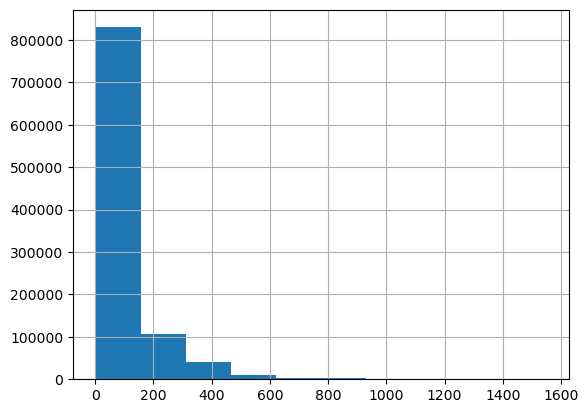

In [262]:
result_df['word_count'].hist()

## Simplificamos chapters y subchapters

In [284]:
from difflib import SequenceMatcher
from itertools import combinations

def similar(a, b, threshold=0.8):
    """
    Calculate the similarity ratio between two strings.

    Parameters:
    - a, b: The input strings.
    - threshold: The minimum similarity ratio for considering them similar (default is 0.8).

    Returns:
    - A boolean indicating whether the strings are similar.
    """
    return SequenceMatcher(None, a, b).ratio() >= threshold

def find_similar_pairs(elements, threshold=0.8):
    """
    Find all pairs of similar elements in a list.

    Parameters:
    - elements: The list of elements to compare.
    - threshold: The minimum similarity ratio for considering elements similar (default is 0.8).

    Returns:
    - A list of tuples representing similar pairs.
    """
    similar_pairs = []

    for pair in combinations(elements, 2):
        if similar(pair[0], pair[1], threshold):
            similar_pairs.append(pair)

    return similar_pairs

# Example list of elements
# element_list = original_list[
#     'apple',
#     'banana',
#     'orange',
#     'apples',
#     'kiwi',
#     'appl',
#     'orangee'
# ]
element_list = original_list.copy()
# Set the threshold for similarity
similarity_threshold = 0.7

# Find all pairs of similar elements in the list
similar_pairs = find_similar_pairs(element_list, similarity_threshold)

# Display the result
print("Similar pairs:")
for pair in similar_pairs:
    print(pair)

Similar pairs:
('CONTRATOS SOBRE PERSONAS JURÍDICAS', 'COntRAtOS SObRe PeRSOnAS JURídICAS')
('CONTRATOS SOBRE PERSONAS JURÍDICAS', 'CONTRTOS SOBRE PERSONAS JURÍDICAS')
('CONTRATOS SOBRE PERSONAS JURÍDICAS', 'CONTRATOS SOBRE PERSONAS JURÍDICAS ')
('CONVOCATORIAS Y AVISOS COMERCIALES', 'COnvOCAtORIAS y AvISOS COMErcIAleS')
('CONVOCATORIAS Y AVISOS COMERCIALES', 'CONVOCATORIAS Y AVISOS COMERCIALES ')
('EDICTOS JUDICIALES', 'EDICTOS JUDICIALES ')
('PARTIDOS POLÍTICOS', 'PARtIdOS POlítICOS')
('PARTIDOS POLÍTICOS', 'PARTIDOS POLÍTICOS ')
('COntRAtOS SObRe PeRSOnAS JURídICAS', 'CONTRTOS SOBRE PERSONAS JURÍDICAS')
('COntRAtOS SObRe PeRSOnAS JURídICAS', 'CONTRATOS SOBRE PERSONAS JURÍDICAS ')
('COnvOCAtORIAS y AvISOS COMErcIAleS', 'CONVOCATORIAS Y AVISOS COMERCIALES ')
('PARtIdOS POlítICOS', 'PARTIDOS POLÍTICOS ')
('CONTRTOS SOBRE PERSONAS JURÍDICAS', 'CONTRATOS SOBRE PERSONAS JURÍDICAS ')


### chapters

In [307]:
chapter_ls = result_df.chapter.unique().tolist()
chapter_ls = [l for l in chapter_ls if l is not np.nan]
edited_ls = ['_'.join(l.lower().split(' ')) for l in chapter_ls]

In [308]:
# Set the threshold for similarity
similarity_threshold = 0.8

# Replace similar elements in the list
cleaned_list = replace_similar(edited_ls, similarity_threshold)


chapter_d = dict(zip(chapter_ls,cleaned_list))

# Display the result
for original, cleaned in zip(chapter_ls, cleaned_list):
    print(f"Original: {original}, Cleaned: {cleaned}")

Original: CONTRATOS SOBRE PERSONAS JURÍDICAS, Cleaned: contratos_sobre_personas_jurídicas
Original: CONVOCATORIAS Y AVISOS COMERCIALES, Cleaned: convocatorias_y_avisos_comerciales
Original: EDICTOS JUDICIALES, Cleaned: edictos_judiciales
Original: PARTIDOS POLÍTICOS, Cleaned: partidos_políticos
Original: COntRAtOS SObRe PeRSOnAS JURídICAS, Cleaned: contratos_sobre_personas_jurídicas
Original: COnvOCAtORIAS y AvISOS COMeRCIAleS, Cleaned: convocatorias_y_avisos_comerciales
Original: edICtOS JUdICIAleS, Cleaned: edictos_judiciales
Original: PARtIdOS POlítICOS, Cleaned: partidos_políticos
Original: BALANCES, Cleaned: balances
Original: CONVOCATORIAS Y AVISOS COMERCIALES , Cleaned: convocatorias_y_avisos_comerciales
Original: EDICTOS JUDICIALES , Cleaned: edictos_judiciales
Original: PARTIDOS POLÍTICOS , Cleaned: partidos_políticos
Original: CONTRTOS SOBRE PERSONAS JURÍDICAS, Cleaned: contratos_sobre_personas_jurídicas
Original: CONTRATOS SOBRE PERSONAS JURÍDICAS , Cleaned: contratos_sobre_

In [314]:
result_df['chapter'] = result_df['chapter'].apply(
    lambda x: next((value for key, value in chapter_d.items() if isinstance(x, str) and x in key), x)
)
result_df['chapter'].unique()

array([nan, 'contratos_sobre_personas_jurídicas',
       'convocatorias_y_avisos_comerciales', 'edictos_judiciales',
       'partidos_políticos', 'balances'], dtype=object)

### subchapters

In [315]:
chapter_ls = result_df.subchapter.unique().tolist()
chapter_ls = [l for l in chapter_ls if l is not np.nan]
edited_ls = ['_'.join(l.lower().split(' ')) for l in chapter_ls]

In [343]:
chapter_ls = result_df.subchapter.unique().tolist()
chapter_ls = [l for l in chapter_ls if l is not np.nan]

chapter_ls = sorted(chapter_ls)

In [344]:
bue_ls = [l for l in chapter_ls if 'Buenos Aires,Año'  in l]
chapter_ls = [l for l in chapter_ls if 'Buenos Aires,Año' not in l]
edited_ls = ['_'.join(l.lower().split(' ')) for l in chapter_ls]

In [337]:
similarity_threshold = 0.8

cleaned_list = replace_similar(edited_ls, similarity_threshold)

chapter_d = dict(zip(chapter_ls,cleaned_list))

for original, cleaned in zip(chapter_ls, cleaned_list):
    print(f"Original: {original}, Cleaned: {cleaned}")

Original: AVISOS COMERCIALES, Cleaned: avisos_comerciales
Original: AVISOS COMERCIALES , Cleaned: avisos_comerciales
Original: AvISOS COMeRCIAleS, Cleaned: avisos_comerciales
Original: BALANCES, Cleaned: balances
Original: BALANCES , Cleaned: balances
Original: CITACIONES Y NOTIFICACIONES. CONCURSOS Y QUIEBRAS. OTROS, Cleaned: citaciones_y_notificaciones._concursos_y_quiebras._otros
Original: CITACIONES Y NOTIFICACIONES. CONCURSOS Y QUIEBRAS. OTROS , Cleaned: citaciones_y_notificaciones._concursos_y_quiebras._otros
Original: CItACIOneS y nOtIfICACIOneS. COnCURSOS y QUIebRAS. OtROS, Cleaned: citaciones_y_notificaciones._concursos_y_quiebras._otros
Original: CONVOCATORIAS, Cleaned: convocatorias
Original: CONVOCATORIAS , Cleaned: convocatorias
Original: COnvOCAtORIAS, Cleaned: convocatorias
Original: OTRAS SOCIEDADES, Cleaned: otras_sociedades
Original: OTRAS SOCIEDADES , Cleaned: otras_sociedades
Original: PARTIDOS POLÍTICOS, Cleaned: partidos_políticos
Original: PARTIDOS POLÍTICOS , Cl

In [347]:
bue_d = dict(zip(bue_ls,['buenos_aires' for l in bue_ls]))

In [350]:
def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

new_chapter_d = Merge(chapter_d, bue_d)

In [352]:
result_df['subchapter'] = result_df['subchapter'].apply(
    lambda x: next((value for key, value in new_chapter_d.items() if isinstance(x, str) and x in key), x)
)
result_df['subchapter'].unique()

array([nan, 'buenos_aires', 'sociedades_anónimas',
       'sociedades_de_responsabilidad_limitada', 'convocatorias',
       'avisos_comerciales', 'remates_comerciales',
       'citaciones_y_notificaciones._concursos_y_quiebras._otros',
       'sucesiones', 'remates_judiciales',
       'transferencias_de__fondo_de_comercio_',
       'sociedades_en_comandita_por_acciones', 'otras_sociedades',
       'balances', 'sociedades_por_acción_simplificada',
       'partidos_políticos'], dtype=object)

In [294]:
len(result_df[(result_df['chapter']=='CONTRATOS SOBRE PERSONAS JURÍDICAS')&(result_df['word_count']>180)])

56769

In [355]:
# result_df[(result_df['chapter']=='CONTRATOS SOBRE PERSONAS JURÍDICAS')&(result_df['word_count']>180)].text.tolist()[3]

In [356]:
result_df.groupby('chapter').mean('word_count').round(0).sort_values(by='word_count',ascending=False)

,index,page,size,word_count
chapter,,,,
partidos_políticos,781.0,85.0,11.0,128.0
balances,655.0,75.0,10.0,117.0
contratos_sobre_personas_jurídicas,146.0,16.0,10.0,102.0
convocatorias_y_avisos_comerciales,501.0,56.0,10.0,68.0
edictos_judiciales,718.0,79.0,9.0,66.0


In [358]:
result_df.subchapter.unique()

array([nan, 'buenos_aires', 'sociedades_anónimas',
       'sociedades_de_responsabilidad_limitada', 'convocatorias',
       'avisos_comerciales', 'remates_comerciales',
       'citaciones_y_notificaciones._concursos_y_quiebras._otros',
       'sucesiones', 'remates_judiciales',
       'transferencias_de__fondo_de_comercio_',
       'sociedades_en_comandita_por_acciones', 'otras_sociedades',
       'balances', 'sociedades_por_acción_simplificada',
       'partidos_políticos'], dtype=object)

### elíminamos filas de títulos

In [368]:
ratio = len(result_df[result_df['text']==result_df['title']])/len(result_df)*100
print(f'{np.round(ratio,0)} % de las filas se corresponden con títulos de documentos')

33.0 % de las filas se corresponden con títulos de documentos


In [369]:
len(result_df[result_df['text']!=result_df['title']])

664749

In [372]:
result_df2 = result_df[result_df['text']!=result_df['title']]

In [373]:
base_path = r'C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner'
if is_valid_path(base_path):
    result_df2.to_pickle(os.path.join(base_path,'result_df2.pkl'))

### mark for duplicates

In [390]:
result_df2['mark'] = (result_df2['title'] == result_df2['title'].shift()).astype(int)

C:\Users\juani\AppData\Local\Temp\ipykernel_6040\1865820781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df2['mark'] = (result_df2['title'] == result_df2['title'].shift()).astype(int)


In [402]:
ls = result_df2['mark'].tolist()

updated_list = [
    1 if ls[i+1] == 1 and ls[i ] == 0 else ls[i]
    for i in range(len(ls) - 1)
]

In [410]:
result_df2['mark'] = updated_list+[1]

C:\Users\juani\AppData\Local\Temp\ipykernel_6040\558092760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df2['mark'] = updated_list+[1]


In [386]:
len(result_df2[(result_df2['subchapter']=='buenos_aires')])

30597

# Back up

In [23]:
# doc = fitz.open(sys.argv[1])
page = doc[2]

import sys

import fitz


def flags_decomposer(flags):
    """Make font flags human readable."""
    l = []
    if flags & 2 ** 0:
        l.append("superscript")
    if flags & 2 ** 1:
        l.append("italic")
    if flags & 2 ** 2:
        l.append("serifed")
    else:
        l.append("sans")
    if flags & 2 ** 3:
        l.append("monospaced")
    else:
        l.append("proportional")
    if flags & 2 ** 4:
        l.append("bold")
    return ", ".join(l)




# read page text as a dictionary, suppressing extra spaces in CJK fonts
blocks = page.get_text("dict", flags=11)["blocks"]
for b in blocks:  # iterate through the text blocks
    for l in b["lines"]:  # iterate through the text lines
        for s in l["spans"]:  # iterate through the text spans
            print("")
            font_properties = "Font: '%s' (%s), size %g, color #%06x" % (
                s["font"],  # font name
                flags_decomposer(s["flags"]),  # readable font flags
                s["size"],  # font size
                s["color"],  # font color
            )
            print("Text: '%s'" % s["text"])  # simple print of text
            print(font_properties)


Text: ' '
Font: 'HelveticaNeueLTStd-LtCn' (serifed, proportional), size 10, color #000000

Text: 'BOLETÍN OFICIAL Nº 35.214 - '
Font: 'HelveticaNeueLTStd-Cn' (serifed, proportional), size 10, color #000000

Text: 'Segunda Sección'
Font: 'HelveticaNeueLTStd-BdCn' (serifed, proportional, bold), size 10, color #000000

Text: ' '
Font: 'HelveticaNeueLTStd-LtCn' (serifed, proportional), size 10, color #000000

Text: '3'
Font: 'HelveticaNeueLTStd-BdCn' (serifed, proportional, bold), size 14, color #000000

Text: ' '
Font: 'HelveticaNeueLTStd-LtCn' (serifed, proportional), size 10, color #000000

Text: 'Miércoles 19 de julio de 2023'
Font: 'HelveticaNeueLTStd-LtCn' (serifed, proportional), size 10, color #000000

Text: 'CONTRATOS SOBRE PERSONAS JURÍDICAS'
Font: 'HelveticaNeueLTStd-Bd' (serifed, proportional, bold), size 17, color #ffffff

Text: 'SOCIEDADES ANÓNIMAS'
Font: 'HelveticaNeueLTStd-Bd' (serifed, proportional, bold), size 14, color #000000

Text: 'ACEGO S.A.'
Font: 'HelveticaNeueLTS